# Pretrained Image Model to Predict Pet Popularity

- Pretrained **EfficientNetB0 model from Keras applications** 는 모두 224 x 224 로 size 맞춘 이미지에 features extract하기 위해서 사용되었습니다. 
- Popularity score는 images 만을 기준으로 측정했습니다. 
- 따라서 위 코드에서는 정형 데이터(Photo Metadata)는 고려하지 않았습니다. 
- image quality가 Popularity 측정에 영향을 끼치기 때문에, 오직 좌우 반전 만 데이터 증강(data augmentation)에 사용되었습니다.

In [1]:
# library
import os
import random

import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

2021-10-21 21:15:41.780413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# 정형 데이터 파일경로
TRAIN_DATA_PATH = '../input/petfinder-pawpularity-score/train.csv'
TEST_DATA_PATH = '../input/petfinder-pawpularity-score/test.csv'

# 이미지 데이터 폴더
TRAIN_DIRECTORY = '../input/petfinder-pawpularity-score/train'
TEST_DIRECTORY = '../input/petfinder-pawpularity-score/test'

In [3]:
# 정형 데이터 처리를 위한 parameters
TARGET_NAME = 'Pawpularity'
VAL_SIZE = 0.15
SEED = 5

In [4]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 224
BATCH_SIZE = 64
DROPOUT_RATE = 0.2
LEARNING_RATE = 1e-3
DECAY_STEPS = 100
DECAY_RATE = 0.96
EPOCHS = 500
PATIENCE = 5

In [5]:
# Pretrained image classification model EfficientNetB0이 사용되었고
# tf.keras.applications로 부터 global average pooling이 final layer에 사용되었습니다.
# model is loaded 캐글 공공데이터셋 https://www.kaggle.com/ekaterinadranitsyna/keras-applications-models 
IMG_MODEL = '../input/keras-applications-models/EfficientNetB0.h5'

## Functions

In [6]:
def set_seed(seed=42):
    # 코드 재생산성을 위해 seed 고정
    
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


def set_display():
    
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format


def id_to_path(img_id: str, dir: str):
    # 이미지 파일 경로 return 

    return os.path.join(dir, f'{img_id}.jpg')


@tf.function
def get_image(path: str) -> tf.Tensor:
    # 이미지 load 하고 전처리 후 Tensor 형태로 전처리 된 이미지 return 함

    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE), dtype=tf.int32)
    return tf.keras.applications.efficientnet.preprocess_input(image)


@tf.function
def process_dataset(path: str, label: int) -> tuple:
    # return 전처리 된 이미지(resize, 좌우반전), numeric label 
    
    return get_image(path), label


@tf.function
def get_dataset(x, y=None) -> tf.data.Dataset:
    """Function creates batched optimized dataset for the model
    out of an array of file paths and (optionally) class labels.
    :param x: Input data for the model (array of file paths)
    :param y: Target values for the model (array of class indexes)
    :return TensorFlow Dataset object
    """
    if y is not None:
        ds = tf.data.Dataset.from_tensor_slices((x, y))
        return ds.map(process_dataset, num_parallel_calls=AUTOTUNE) \
            .batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices(x)
        return ds.map(get_image, num_parallel_calls=AUTOTUNE) \
            .batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


def plot_history(hist):
    # training and validation 행렬을 차트 그리는 함수

    # Losses and metrics
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    rmse = hist.history['root_mean_squared_error']
    val_rmse = hist.history['val_root_mean_squared_error']

    # Epochs to plot along x axis
    x_axis = range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    ax1.plot(x_axis, loss, 'bo', label='Training')
    ax1.plot(x_axis, val_loss, 'ro', label='Validation')
    ax1.set_title('MSE Loss')
    ax1.legend()

    ax2.plot(x_axis, rmse, 'bo', label='Training')
    ax2.plot(x_axis, val_rmse, 'ro', label='Validation')
    ax2.set_title('Root Mean Squared Error')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Data Processing

In [7]:
set_seed(SEED)
set_display()

In [8]:
# Train data set
data_train = pd.read_csv(TRAIN_DATA_PATH)
print(f'Train data shape: {data_train.shape}')
data_train.head()

Train data shape: (9912, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
# Test data set
data_test = pd.read_csv(TEST_DATA_PATH)
print(f'Test data shape: {data_test.shape}')
data_test.head()

Test data shape: (8, 13)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [10]:
# train and test images 경로 재설정
data_train['path'] = data_train['Id'].apply(
    lambda x: id_to_path(x, TRAIN_DIRECTORY))
data_test['path'] = data_test['Id'].apply(
    lambda x: id_to_path(x, TEST_DIRECTORY))

# VAL_SIZE = 0.15 만큼 train, valid 분리
train_subset, valid_subset = train_test_split(
    data_train[['path', TARGET_NAME]],
    test_size=VAL_SIZE
    , shuffle=True, random_state=SEED
)

In [11]:
# TensorFlow datasets 생성
train_ds = get_dataset(x=train_subset['path'], y=train_subset[TARGET_NAME])
valid_ds = get_dataset(x=valid_subset['path'], y=valid_subset[TARGET_NAME])
test_ds = get_dataset(x=data_test['path'])

2021-10-21 21:15:46.913983: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-21 21:15:46.917102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-21 21:15:46.953939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 21:15:46.954598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-21 21:15:46.954658: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-21 21:15:46.979811: I tensorflow/stream_executor/platform/def

In [12]:
# Pretrained image classification model
feature_model = tf.keras.models.load_model(IMG_MODEL)

# Freeze weights in the original model(weights 고정)
feature_model.trainable = False

In [13]:
# 이 모델은 Input으로  224 x 224 사이즈의 이미지들을 받고, 랜덤하게 좌우반전을 적용한다.(only in the train mode)
# pretrained passes feature extraction 모델을 통해 image arrays 보내고,
# target score 얻기 위해서 batch normalization, dropout, activations(relu)를 적용한다. 

image_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
        feature_model,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT_RATE, name='top_dropout'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, name='score')
    ]
)

In [14]:
# 점차적으로 learning rate 감소
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE,
    staircase=True)

In [15]:
# Compile the model
image_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [16]:
image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992     
_________________________________________________________________
score (Dense)                (None, 1)                 33        
Total params: 4,095,716
Trainable params: 43,585
Non-trainable params: 4,052,131
_________________________________________

In [17]:
# EarlyStopping 이용하여 validation loss 모니터링 하고, training 멈춤
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

In [18]:
history = image_model.fit(train_ds, validation_data=valid_ds,
                          epochs=EPOCHS, callbacks=[early_stop],
                          use_multiprocessing=True, workers=-1)

Epoch 1/500


2021-10-21 21:15:58.308652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-21 21:15:59.364124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-21 21:15:59.405037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


132/132 [==============================] - 64s 393ms/step - loss: 1212.7984 - root_mean_squared_error: 34.4746 - val_loss: 647.9258 - val_root_mean_squared_error: 25.4544
Epoch 2/500
132/132 [==============================] - 35s 261ms/step - loss: 385.1966 - root_mean_squared_error: 19.6197 - val_loss: 428.6970 - val_root_mean_squared_error: 20.7050
Epoch 3/500
132/132 [==============================] - 34s 260ms/step - loss: 355.7977 - root_mean_squared_error: 18.8604 - val_loss: 374.4747 - val_root_mean_squared_error: 19.3513
Epoch 4/500
132/132 [==============================] - 35s 262ms/step - loss: 348.4124 - root_mean_squared_error: 18.6632 - val_loss: 366.5267 - val_root_mean_squared_error: 19.1449
Epoch 5/500
132/132 [==============================] - 35s 261ms/step - loss: 336.5780 - root_mean_squared_error: 18.3435 - val_loss: 364.3203 - val_root_mean_squared_error: 19.0872
Epoch 6/500
132/132 [==============================] - 34s 259ms/step - loss: 333.5586 - root_mean_sq

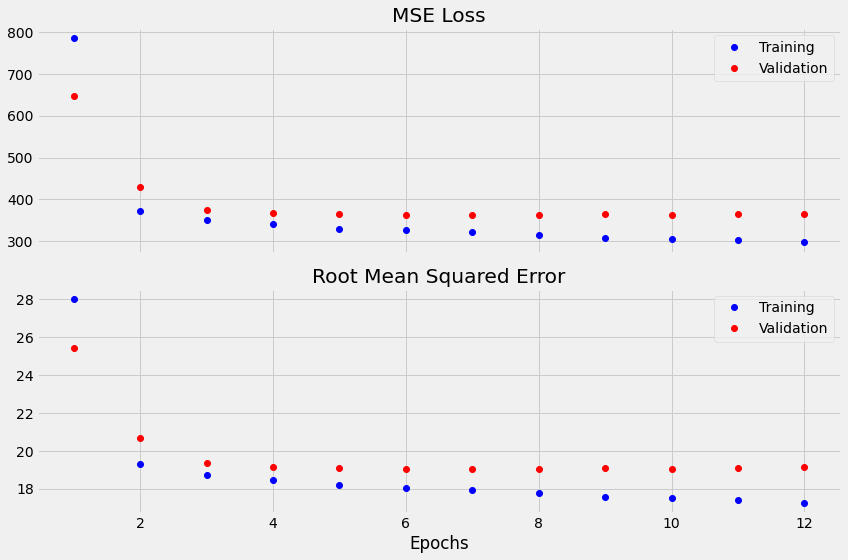

In [19]:
plot_history(history)

## Inference

In [20]:
# test data에서 pularity score 예측
data_test[TARGET_NAME] = image_model.predict(
    test_ds, use_multiprocessing=True, workers=os.cpu_count())

In [21]:
# submission file 제출
data_test[['Id', TARGET_NAME]].to_csv('submission.csv', index=False)
data_test[['Id', TARGET_NAME]].head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,53.1368
1,43a2262d7738e3d420d453815151079e,53.7746
2,4e429cead1848a298432a0acad014c9d,52.9461
3,80bc3ccafcc51b66303c2c263aa38486,52.3971
4,8f49844c382931444e68dffbe20228f4,48.9280
